In [1]:
import sys
sys.path.append('/Users/pschulam/Git/mypy')

In [115]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nips15
import online
%matplotlib inline

In [287]:
folds_dir = 'models/jmlr/folds'

def load_model(marker, fold, folds_dir=folds_dir):
    param_dir = os.path.join(folds_dir, marker, '{:02d}'.format(fold), 'param')
    return nips15.NipsModel.from_directory(param_dir)

def get_posteriors(model, data, censor=None):
    if censor is None:
        P = [model.posterior(*d.unpack()) for d in data]
    else:
        P = [model.posterior(*d.truncate(censor).unpack()) for d in data]
        
    return np.array(P)

def get_log_priors(model, data, censor=None):
    if censor is None:
        LP = [model.prior(*d.unpack()) for d in data]
    else:
        LP = [model.posterior(*d.truncate(censor).unpack()) for d in data]
        
    return np.array(LP)

def get_log_likels(model, data, censor=None):
    if censor is None:
        LL = [model.likelihood(*d.unpack()) for d in data]
    else:
        LL = [model.likelihood(*d.unpack()) for d in data]
        
    return np.array(LL)

In [288]:
pfvc_spec = {'t' : 'years_seen_full',
             'y' : 'pfvc',
             'x1': ['female', 'afram'],
             'x2': ['female', 'afram', 'aca', 'scl']}

pfvc    = pd.read_csv('data/benchmark_pfvc.csv')
pfvc_pd = [nips15.PatientData.from_tbl(tbl, **pfvc_spec) for _, tbl in pfvc.groupby('ptid')]

tss_spec = {'t' : 'years_seen',
            'y' : 'tss',
            'x1': ['female', 'afram'],
            'x2': ['female', 'afram']}

tss = pd.read_csv('data/benchmark_tss.csv')
tss_match = ['ptid'] + tss_spec['x1']
tss = pd.merge(pfvc[tss_match], tss, 'left', tss_match)
tss_pd = [nips15.PatientData.from_tbl(tbl, **tss_spec) for _, tbl in tss.groupby('ptid')]

pdlco_spec = {'t' : 'years_seen',
              'y' : 'pdlco',
              'x1': ['female', 'afram'],
              'x2': ['female', 'afram']}

pdlco = pd.read_csv('data/benchmark_pdc.csv')
pdlco_match = ['ptid'] + pdlco_spec['x1']
pdlco = pd.merge(pfvc[pdlco_match], pdlco, 'left', pdlco_match)
pdlco_pd = [nips15.PatientData.from_tbl(tbl, **pdlco_spec) for _, tbl in pdlco.groupby('ptid')]

pv1_spec = {'t' : 'years_seen',
            'y' : 'pfev1',
            'x1': ['female', 'afram'],
            'x2': ['female', 'afram']}

pv1 = pd.read_csv('data/benchmark_pv1.csv')
pv1_match = ['ptid'] + pv1_spec['x1']
pv1 = pd.merge(pfvc[pv1_match], pv1, 'left', pv1_match)
pv1_pd = [nips15.PatientData.from_tbl(tbl, **pv1_spec) for _, tbl in pv1.groupby('ptid')]

sp_spec = {'t' : 'years_seen',
           'y' : 'rvsp',
           'x1': ['female', 'afram'],
           'x2': ['female', 'afram']}

sp = pd.read_csv('data/benchmark_sp.csv')
sp_match = ['ptid'] + sp_spec['x1']
sp = pd.merge(pfvc[sp_match], sp, 'left', sp_match)
sp_pd = [nips15.PatientData.from_tbl(tbl, **sp_spec) for _, tbl in sp.groupby('ptid')]

In [292]:
get_ptids = lambda pd: [p.ptid for p in pd]
pfvc_df   = pd.DataFrame({'ptid': get_ptids(pfvc_pd),  'pfvc' : pfvc_pd}).set_index('ptid')
tss_df    = pd.DataFrame({'ptid': get_ptids(tss_pd),   'tss'  : tss_pd}).set_index('ptid')
pdlco_df  = pd.DataFrame({'ptid': get_ptids(pdlco_pd), 'pdlco': pdlco_pd}).set_index('ptid')
pv1_df    = pd.DataFrame({'ptid': get_ptids(pv1_pd),   'pv1'  : pdlco_pd}).set_index('ptid')
sp_df     = pd.DataFrame({'ptid': get_ptids(sp_pd),    'rvsp'   : sp_pd}).set_index('ptid')

In [290]:
folds_df = pfvc.loc[:, ['ptid', 'fold']].drop_duplicates().set_index('ptid')

In [294]:
patient_data = pd.concat([folds_df, pfvc_df, tss_df, pdlco_df, pv1_df, sp_df], axis=1, join='inner')

In [335]:
model_names = ['pfvc', 'tss', 'pdc', 'pv1']
col_names   = ['pfvc', 'tss', 'pdlco', 'pv1']

In [517]:
folds = [k + 1 for k in range(10)]
censor_time = 3.0

In [518]:
full_posteriors = np.zeros((patient_data.shape[0], 8))

for k in folds:
    print('Starting fold {}'.format(k))
    
    model = load_model(model_names[0], k)
    test  = patient_data['fold'].values == k
    Qtest = get_posteriors(model, patient_data['pfvc'][test])
    
    full_posteriors[test, :] = Qtest
    
full_posterior_tbl = pd.DataFrame(full_posteriors)
full_posterior_tbl.index = patient_data.index
full_posterior_tbl.columns = ['p{}'.format(i) for i in range(1, 9)]

Starting fold 1
Starting fold 2
Starting fold 3
Starting fold 4
Starting fold 5
Starting fold 6
Starting fold 7
Starting fold 8
Starting fold 9
Starting fold 10


In [519]:
full_posterior_tbl.to_csv('full_posteriors.csv')

In [509]:
orig_posteriors = np.zeros((patient_data.shape[0], 8))

for k in folds:
    print('Starting fold {}'.format(k))
    
    model = load_model(model_names[0], k)
    test  = patient_data['fold'].values == k
    Qtest = get_posteriors(model, patient_data['pfvc'][test], censor_time)
    
    orig_posteriors[test, :] = Qtest
    
orig_posterior_tbl = pd.DataFrame(orig_posteriors)
orig_posterior_tbl.index = patient_data.index
orig_posterior_tbl.columns = ['p{}'.format(i) for i in range(1, 9)]

Starting fold 1
Starting fold 2
Starting fold 3
Starting fold 4
Starting fold 5
Starting fold 6
Starting fold 7
Starting fold 8
Starting fold 9
Starting fold 10


In [510]:
orig_posterior_tbl.to_csv('orig_posteriors.csv')

In [432]:
imp.reload(online)

<module 'online' from '/Users/pschulam/Git/Notebook/2015/07/online.py'>

In [433]:
posteriors = np.zeros((patient_data.shape[0], 8))
all_aux_clf = []
all_weights = []

for k in folds:
    print('Starting fold {}'.format(k))
    
    models = [load_model(n, k) for n in model_names]
    test   = patient_data['fold'].values == k
    train  = ~test

    Ptrain = get_posteriors(models[0], patient_data['pfvc'][train])
    Qtrain = get_posteriors(models[0], patient_data['pfvc'][train], censor_time)
    QQaux  = []
    for n, m in zip(col_names[1:], models[1:]):
        Qaux = get_posteriors(m, patient_data[n][train], 30.0)
        QQaux.append(Qaux)
    
    bins = [0, 5, 8]
    interp_groups = np.digitize(np.argmax(Qtrain, axis=1), bins) - 1
    aux_clf, weights = online.train_adjustment(Ptrain, Qtrain, QQaux, interp_groups=interp_groups)
    
    Qtest = get_posteriors(models[0], patient_data['pfvc'][test], censor_time)
    QQaux = []
    for n, m in zip(col_names[1:], models[1:]):
        Qaux = get_posteriors(m, patient_data[n][test], 30.0)
        QQaux.append(Qaux)
        
    interp_groups = np.digitize(np.argmax(Qtest, axis=1), bins) - 1
    
    posteriors[test, :] = online.apply_adjustment(Qtest, QQaux, aux_clf, weights, interp_groups)
    np.savetxt('param/adjusted_posteriors.dat', posteriors)
    
    all_aux_clf.append(aux_clf)
    all_weights.append(weights)

Starting fold 1
Starting fold 2
Starting fold 3
Starting fold 4
Starting fold 5
Starting fold 6
Starting fold 7
Starting fold 8
Starting fold 9
Starting fold 10


In [434]:
posterior_tbl = pd.DataFrame(posteriors)
posterior_tbl.index = patient_data.index
posterior_tbl.columns = ['p{}'.format(i) for i in range(1, 9)]

In [435]:
posterior_tbl.to_csv('adju_posteriors.csv')

In [436]:
np.round(np.array(all_weights[0]), 2)

array([[ 0.86,  0.01,  0.1 ,  0.02],
       [ 0.88,  0.05,  0.03,  0.04]])

## Tests

In [520]:
!Rscript score_posteriors.R 3.0 full_posteriors.csv

Loading required package: methods
Source: local data frame [3 x 2]

     bin  mae
1  (3,4] 2.67
2  (4,8] 2.65
3 (8,25] 3.08


In [512]:
!Rscript score_posteriors.R 8.0 orig_posteriors.csv

Loading required package: methods
Source: local data frame [1 x 2]

     bin  mae
1 (8,25] 4.15


In [439]:
!Rscript score_posteriors.R 1.0 adju_posteriors.csv

Loading required package: methods
Source: local data frame [4 x 2]

     bin  mae
1  (1,2] 4.73
2  (2,4] 5.87
3  (4,8] 7.61
4 (8,25] 9.72


In [441]:
!Rscript score_posteriors.R 1.0 lgln_posteriors.csv

Loading required package: methods
Source: local data frame [4 x 2]

     bin  mae
1  (1,2] 4.85
2  (2,4] 6.03
3  (4,8] 7.87
4 (8,25] 9.68


In [472]:
!Rscript score_posteriors.R 1.0 lgln_posteriors_0.0e+00.csv

Loading required package: methods
Source: local data frame [4 x 2]

     bin  mae
1  (1,2] 4.74
2  (2,4] 6.05
3  (4,8] 7.80
4 (8,25] 9.67


In [471]:
!Rscript score_posteriors.R 1.0 lgln_posteriors_1.0e+00.csv

Loading required package: methods
Source: local data frame [4 x 2]

     bin   mae
1  (1,2]  4.91
2  (2,4]  6.11
3  (4,8]  8.25
4 (8,25] 10.70


In [443]:
!Rscript score_posteriors.R 1.0 lgln_posteriors_1.0e-01.csv

Loading required package: methods
Source: local data frame [4 x 2]

     bin   mae
1  (1,2]  4.89
2  (2,4]  6.08
3  (4,8]  8.14
4 (8,25] 10.48


In [444]:
!Rscript score_posteriors.R 1.0 lgln_posteriors_1.0e-02.csv

Loading required package: methods
Source: local data frame [4 x 2]

     bin   mae
1  (1,2]  4.85
2  (2,4]  6.03
3  (4,8]  7.93
4 (8,25] 10.08


In [445]:
!Rscript score_posteriors.R 1.0 lgln_posteriors_1.0e-03.csv

Loading required package: methods
Source: local data frame [4 x 2]

     bin  mae
1  (1,2] 4.83
2  (2,4] 6.02
3  (4,8] 7.85
4 (8,25] 9.68


In [446]:
!Rscript score_posteriors.R 1.0 lgln_posteriors_1.0e-04.csv

Loading required package: methods
Source: local data frame [4 x 2]

     bin  mae
1  (1,2] 4.85
2  (2,4] 6.03
3  (4,8] 7.86
4 (8,25] 9.68


In [447]:
!Rscript score_posteriors.R 1.0 l1_lgln_posteriors_1.0e-02.csv

Loading required package: methods
Source: local data frame [4 x 2]

     bin   mae
1  (1,2]  4.92
2  (2,4]  6.12
3  (4,8]  8.24
4 (8,25] 10.65


In [449]:
!Rscript score_posteriors.R 1.0 l1_lgln_posteriors_1.0e-03.csv

Loading required package: methods
Source: local data frame [4 x 2]

     bin   mae
1  (1,2]  4.85
2  (2,4]  6.09
3  (4,8]  8.00
4 (8,25] 10.03


In [452]:
!Rscript score_posteriors.R 1.0 l1_lgln_posteriors_5.0e-04.csv

Loading required package: methods
Source: local data frame [4 x 2]

     bin   mae
1  (1,2]  4.86
2  (2,4]  6.07
3  (4,8]  8.00
4 (8,25] 10.17


In [453]:
!Rscript score_posteriors.R 1.0 l1_lgln_posteriors_2.5e-04.csv

Loading required package: methods
Source: local data frame [4 x 2]

     bin  mae
1  (1,2] 4.84
2  (2,4] 6.03
3  (4,8] 7.88
4 (8,25] 9.95


In [450]:
!Rscript score_posteriors.R 1.0 l1_lgln_posteriors_1.0e-04.csv

Loading required package: methods
Source: local data frame [4 x 2]

     bin  mae
1  (1,2] 4.83
2  (2,4] 5.99
3  (4,8] 7.83
4 (8,25] 9.80


In [451]:
!Rscript score_posteriors.R 1.0 l1_lgln_posteriors_1.0e-05.csv

Loading required package: methods
Source: local data frame [4 x 2]

     bin  mae
1  (1,2] 4.86
2  (2,4] 6.05
3  (4,8] 7.89
4 (8,25] 9.78


In [469]:
!Rscript score_posteriors.R 1.0 l1_trim_lgln_posteriors_0.0e+00.csv

Loading required package: methods
Source: local data frame [4 x 2]

     bin  mae
1  (1,2] 4.82
2  (2,4] 5.99
3  (4,8] 7.93
4 (8,25] 9.92


In [470]:
!Rscript score_posteriors.R 1.0 l1_trim3_lgln_posteriors_0.0e+00.csv

Loading required package: methods
Source: local data frame [4 x 2]

     bin  mae
1  (1,2] 4.85
2  (2,4] 6.06
3  (4,8] 7.83
4 (8,25] 9.79


In [473]:
!Rscript score_posteriors.R 1.0 l1_full_hac_lgln_posteriors_1.0e-04.csv

Loading required package: methods
Source: local data frame [4 x 2]

     bin   mae
1  (1,2]  4.84
2  (2,4]  6.14
3  (4,8]  7.89
4 (8,25] 10.14


## Analysis of posteriors

In [193]:
from sklearn.metrics import confusion_matrix

In [410]:
def prob_matrix(P, Q):
    k = P.shape[1]
    M = np.zeros((k, k))
    for i in range(k):
        ix = np.argmax(P, axis=1) == i
        M[i, :] = Q[ix, :].mean(axis=0)
    return M

In [343]:
P  = full_posteriors.copy()
Q1 = orig_posteriors.copy()
Q2 = posteriors.copy()

In [421]:
confusion_matrix(np.argmax(P, axis=1), np.argmax(P, axis=1))

array([[ 44,   0,   0,   0,   0,   0,   0,   0],
       [  0, 154,   0,   0,   0,   0,   0,   0],
       [  0,   0,  81,   0,   0,   0,   0,   0],
       [  0,   0,   0,  97,   0,   0,   0,   0],
       [  0,   0,   0,   0,  95,   0,   0,   0],
       [  0,   0,   0,   0,   0,  68,   0,   0],
       [  0,   0,   0,   0,   0,   0,  89,   0],
       [  0,   0,   0,   0,   0,   0,   0,  44]])

In [416]:
np.round(prob_matrix(P, P), 2)

array([[ 0.87,  0.12,  0.01,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.05,  0.73,  0.15,  0.04,  0.02,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.18,  0.59,  0.15,  0.06,  0.  ,  0.02,  0.  ],
       [ 0.  ,  0.05,  0.13,  0.6 ,  0.09,  0.06,  0.08,  0.  ],
       [ 0.  ,  0.03,  0.06,  0.1 ,  0.67,  0.11,  0.03,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.04,  0.14,  0.66,  0.1 ,  0.05],
       [ 0.  ,  0.  ,  0.01,  0.06,  0.04,  0.1 ,  0.74,  0.04],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.01,  0.1 ,  0.06,  0.83]])

In [422]:
confusion_matrix(np.argmax(P, axis=1), np.argmax(Q1, axis=1))

array([[ 35,   6,   2,   1,   0,   0,   0,   0],
       [  3, 109,  26,  12,   0,   1,   2,   1],
       [  3,  13,  58,   3,   0,   0,   4,   0],
       [  1,  18,  18,  35,   5,   6,  14,   0],
       [  0,   1,   1,   7,  56,  10,  14,   6],
       [  0,   0,   1,   1,  23,  34,   4,   5],
       [  0,   2,   8,  11,  16,  10,  42,   0],
       [  0,   0,   0,   2,   3,   3,   1,  35]])

In [462]:
np.round(prob_matrix(P, Q1), 1)

array([[ 0.7,  0.2,  0.1,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0.1,  0.5,  0.2,  0.1,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0.3,  0.4,  0.2,  0. ,  0. ,  0.1,  0. ],
       [ 0. ,  0.2,  0.1,  0.3,  0.1,  0.1,  0.2,  0. ],
       [ 0. ,  0. ,  0. ,  0.1,  0.4,  0.2,  0.2,  0.1],
       [ 0. ,  0. ,  0. ,  0. ,  0.3,  0.4,  0.1,  0.1],
       [ 0. ,  0.1,  0.1,  0.1,  0.2,  0.1,  0.4,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0.1,  0.2,  0. ,  0.7]])

In [457]:
Q3 = pd.read_csv('l1_lgln_posteriors_1.0e-04.csv').iloc[:, 1:]

In [458]:
Q3 = np.array(Q3)

In [465]:
np.round(prob_matrix(P, Q3), 2)

array([[ 0.7 ,  0.21,  0.06,  0.02,  0.01,  0.01,  0.  ,  0.  ],
       [ 0.08,  0.45,  0.24,  0.15,  0.03,  0.03,  0.02,  0.  ],
       [ 0.04,  0.31,  0.22,  0.31,  0.03,  0.02,  0.05,  0.  ],
       [ 0.02,  0.22,  0.17,  0.32,  0.08,  0.08,  0.11,  0.  ],
       [ 0.01,  0.05,  0.04,  0.17,  0.26,  0.29,  0.12,  0.06],
       [ 0.  ,  0.02,  0.02,  0.06,  0.25,  0.4 ,  0.13,  0.12],
       [ 0.  ,  0.04,  0.07,  0.22,  0.13,  0.24,  0.25,  0.04],
       [ 0.  ,  0.01,  0.01,  0.01,  0.08,  0.15,  0.03,  0.71]])

In [467]:
confusion_matrix(np.argmax(P, axis=1), np.argmax(Q3, axis=1))

array([[ 33,  11,   0,   0,   0,   0,   0,   0],
       [  4, 113,  15,  17,   3,   2,   0,   0],
       [  3,  38,  10,  28,   0,   0,   2,   0],
       [  0,  36,  11,  34,   3,   5,   8,   0],
       [  0,   7,   0,  20,  24,  30,   8,   6],
       [  0,   4,   0,   2,  15,  36,   4,   7],
       [  0,   3,   1,  31,   6,  22,  22,   4],
       [  0,   2,   0,   0,   2,   5,   1,  34]])

In [463]:
Q4 = pd.read_csv('lgln_posteriors_full_aux.csv').iloc[:, 1:]
Q4 = np.array(Q4)

In [466]:
np.round(prob_matrix(P, Q4), 2)

array([[ 0.72,  0.21,  0.06,  0.01,  0.01,  0.  ,  0.  ,  0.  ],
       [ 0.11,  0.47,  0.25,  0.1 ,  0.04,  0.02,  0.01,  0.  ],
       [ 0.04,  0.32,  0.28,  0.23,  0.05,  0.02,  0.04,  0.  ],
       [ 0.01,  0.12,  0.26,  0.34,  0.07,  0.05,  0.12,  0.02],
       [ 0.  ,  0.04,  0.05,  0.13,  0.42,  0.23,  0.09,  0.04],
       [ 0.  ,  0.01,  0.04,  0.11,  0.21,  0.29,  0.24,  0.1 ],
       [ 0.  ,  0.02,  0.07,  0.26,  0.08,  0.1 ,  0.41,  0.05],
       [ 0.  ,  0.  ,  0.01,  0.02,  0.02,  0.09,  0.09,  0.76]])

In [468]:
confusion_matrix(np.argmax(P, axis=1), np.argmax(Q4, axis=1))

array([[35,  7,  2,  0,  0,  0,  0,  0],
       [14, 88, 31, 14,  6,  1,  0,  0],
       [ 3, 31, 22, 21,  2,  0,  2,  0],
       [ 1, 11, 19, 46,  6,  4,  9,  1],
       [ 0,  2,  2, 16, 49, 16,  7,  3],
       [ 0,  0,  3,  6, 16, 19, 18,  6],
       [ 0,  2,  3, 27,  6,  7, 40,  4],
       [ 0,  0,  0,  2,  0,  3,  3, 36]])

In [419]:
k1 = patient_data['fold'].values == 2
np.mean(np.argmax(P[k1, :], axis=1) == np.argmax(Q1[k1, :], axis=1))

0.59259259259259256

In [344]:
(np.argmax(P, axis=1) == np.argmax(Q1, axis=1)).mean()

0.60119047619047616

In [345]:
(np.argmax(P, axis=1) == np.argmax(Q2, axis=1)).mean()

0.57738095238095233

In [346]:
confusion_matrix(np.argmax(P, axis=1), np.argmax(Q1, axis=1))

array([[ 35,   6,   2,   1,   0,   0,   0,   0],
       [  3, 109,  26,  12,   0,   1,   2,   1],
       [  3,  13,  58,   3,   0,   0,   4,   0],
       [  1,  18,  18,  35,   5,   6,  14,   0],
       [  0,   1,   1,   7,  56,  10,  14,   6],
       [  0,   0,   1,   1,  23,  34,   4,   5],
       [  0,   2,   8,  11,  16,  10,  42,   0],
       [  0,   0,   0,   2,   3,   3,   1,  35]])

In [347]:
confusion_matrix(np.argmax(P, axis=1), np.argmax(Q2, axis=1))

array([[ 31,  12,   0,   1,   0,   0,   0,   0],
       [  3, 114,  21,  12,   0,   2,   2,   0],
       [  2,  26,  45,   2,   2,   0,   4,   0],
       [  0,  27,  13,  30,   5,   6,  16,   0],
       [  0,   2,   0,   6,  56,  10,  15,   6],
       [  0,   1,   0,   1,  24,  33,   4,   5],
       [  0,   3,   7,   9,  16,   9,  45,   0],
       [  0,   0,   0,   2,   3,   4,   1,  34]])

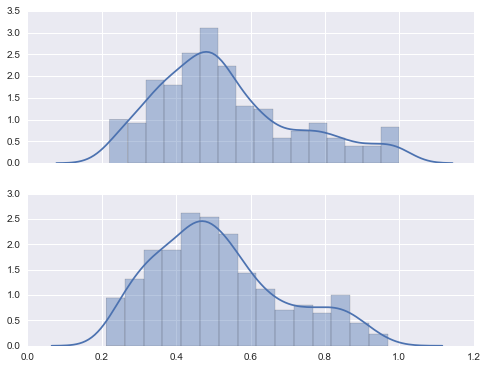

In [348]:
fig, ax = plt.subplots(2, sharex=True, figsize=(8, 6))
_ = sns.distplot(np.max(Q1, axis=1), ax=ax[0])
_ = sns.distplot(np.max(Q2, axis=1), ax=ax[1])

In [349]:
z  = np.argmax(P, axis=1)
z1 = np.argmax(Q1, axis=1)
c1 = np.max(Q1, axis=1)
z2 = np.argmax(Q2, axis=1)
c2 = np.max(Q2, axis=1)

In [350]:
def conf_restricted_acc(z, zhat, conf, min_conf):
    valid = conf >= min_conf
    return (z[valid] == zhat[valid]).mean()

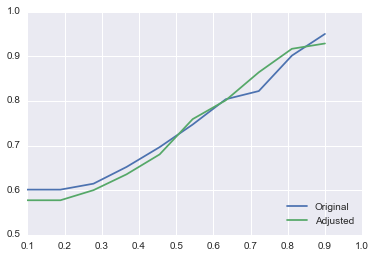

In [351]:
x  = np.linspace(0.1, 0.9, 10)
y1 = [conf_restricted_acc(z, z1, c1, a) for a in x]
y2 = [conf_restricted_acc(z, z2, c2, a) for a in x]
l1 = plt.plot(x, y1, label='Original')
l2 = plt.plot(x, y2, label='Adjusted')
_  = plt.ylim(0.5, 1.0)
_  = plt.legend(loc=4)